Analyzing metrics for benchmark: bayesian_games_29_7
Metrics by Model for benchmark 'bayesian_games_29_7':
      model  accuracy with eval
 qwen2.5:3b                85.8
llama3.2:1b                69.0
   llama3.3                94.6


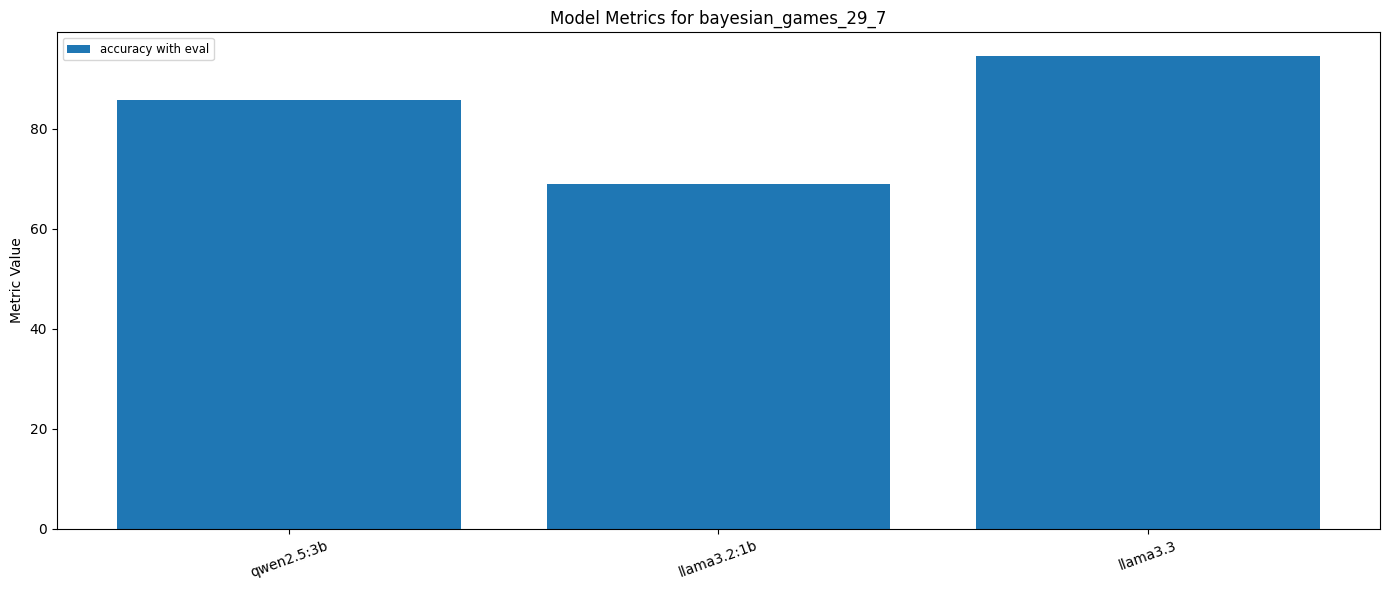

Analyzing metrics for benchmark: bullet_journaling_145_1
Metrics by Model for benchmark 'bullet_journaling_145_1':
      model  accuracy with eval
 qwen2.5:3b                74.6
llama3.2:1b                66.7
   llama3.3                92.0


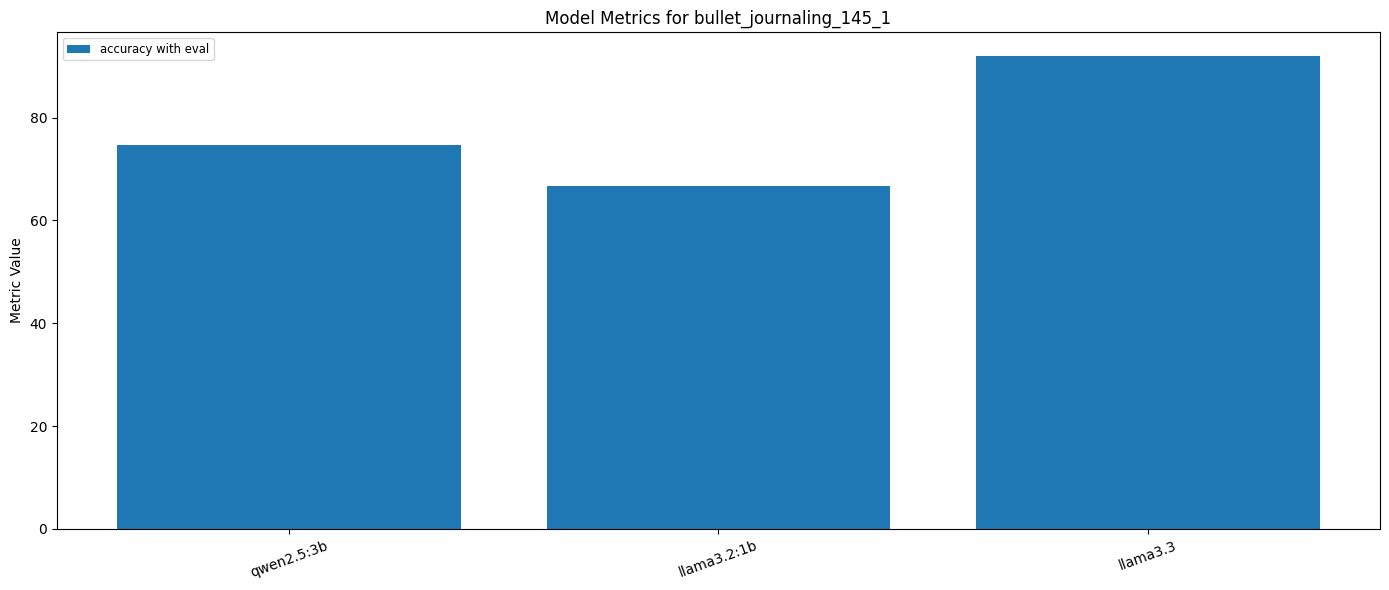

Analyzing metrics for benchmark: canopy_management_298_8
Metrics by Model for benchmark 'canopy_management_298_8':
      model  accuracy with eval
 qwen2.5:3b                86.3
llama3.2:1b                72.5
   llama3.3                92.9


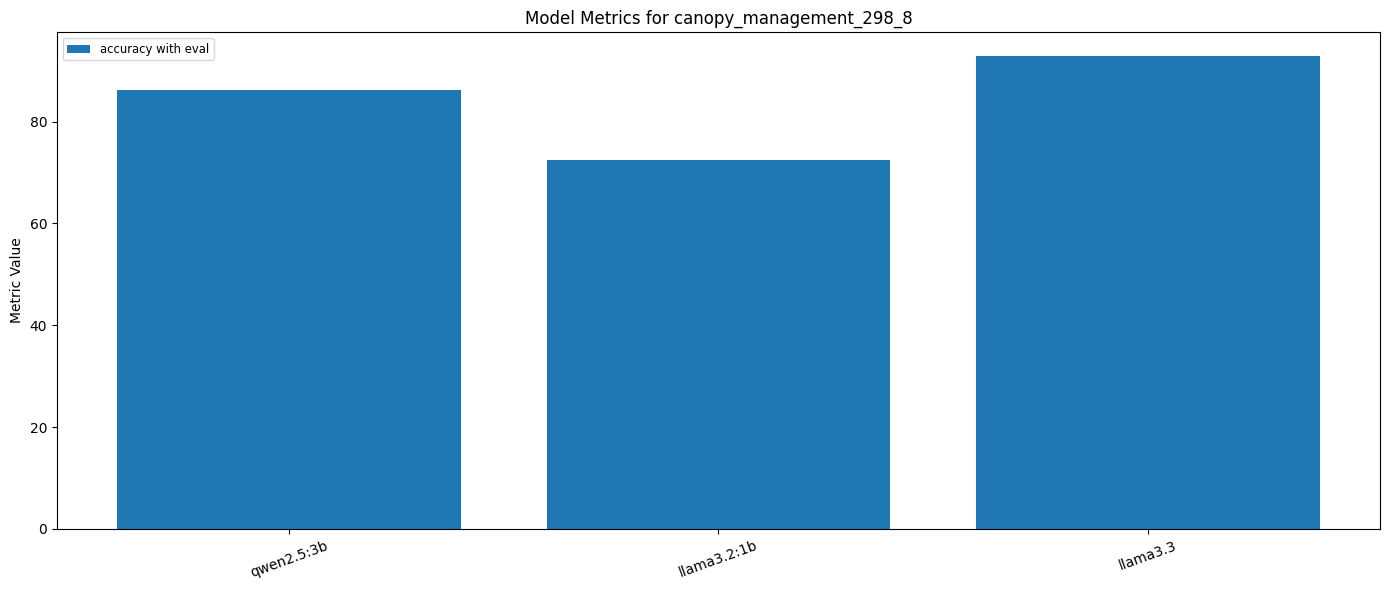

Analyzing metrics for benchmark: fancy_title_generator
Metrics by Model for benchmark 'fancy_title_generator':
      model  accuracy with eval
 qwen2.5:3b                52.5
llama3.2:1b                78.5
   llama3.3                83.5


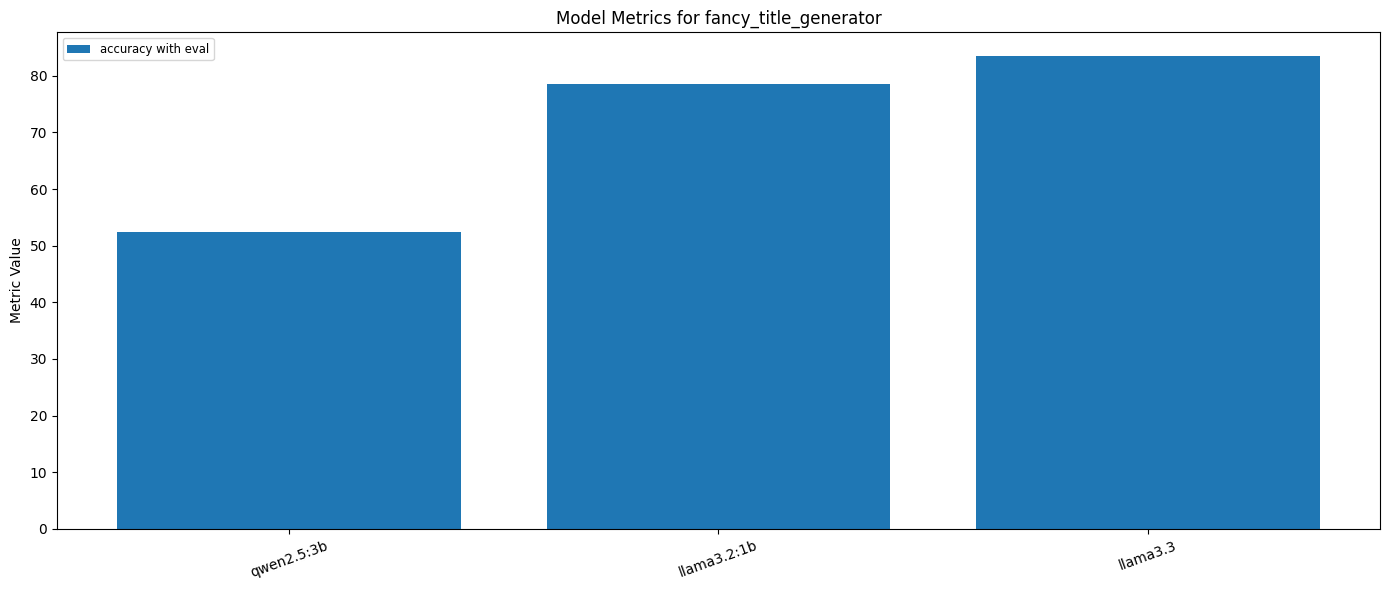

Analyzing metrics for benchmark: hearing_impairments_124_7
Metrics by Model for benchmark 'hearing_impairments_124_7':
      model  accuracy with eval
 qwen2.5:3b                90.1
llama3.2:1b                76.5
   llama3.3                95.0


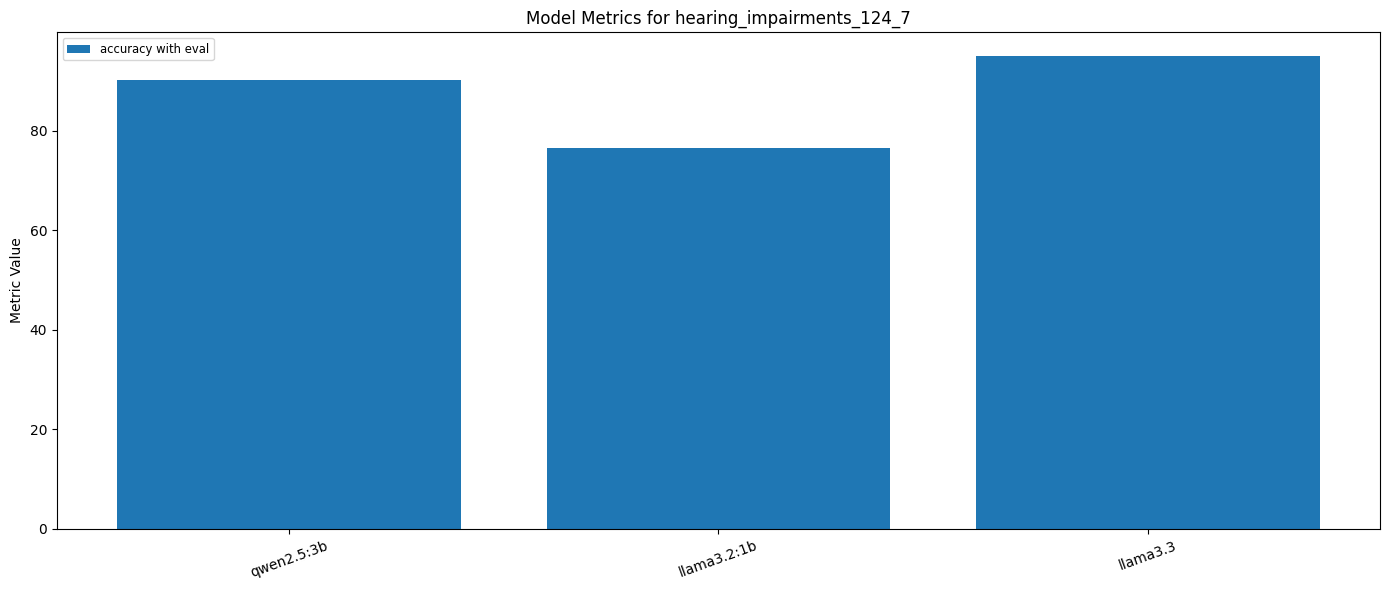

Analyzing metrics for benchmark: housing_market_dynamics_338_1
Metrics by Model for benchmark 'housing_market_dynamics_338_1':
      model  accuracy with eval
 qwen2.5:3b                74.9
llama3.2:1b                67.7
   llama3.3                89.2


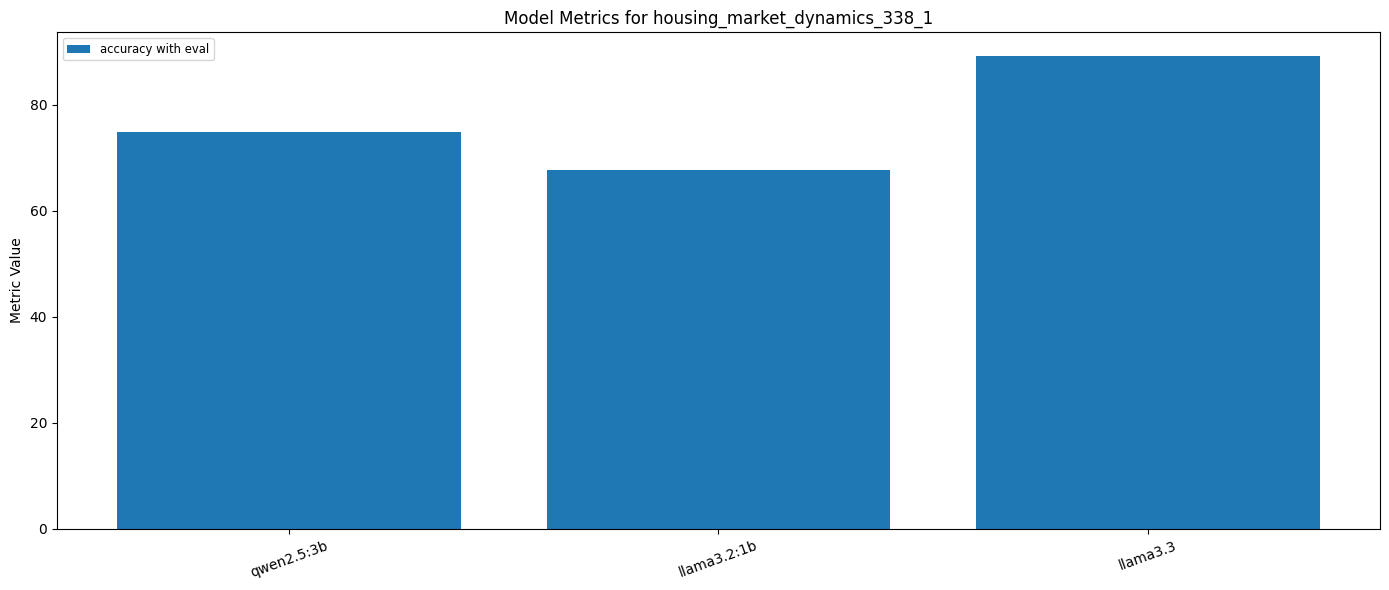

Analyzing metrics for benchmark: initial_public_offerings_ipos_70_9
Metrics by Model for benchmark 'initial_public_offerings_ipos_70_9':
      model  accuracy with eval
 qwen2.5:3b                81.5
llama3.2:1b                69.5
   llama3.3                91.5


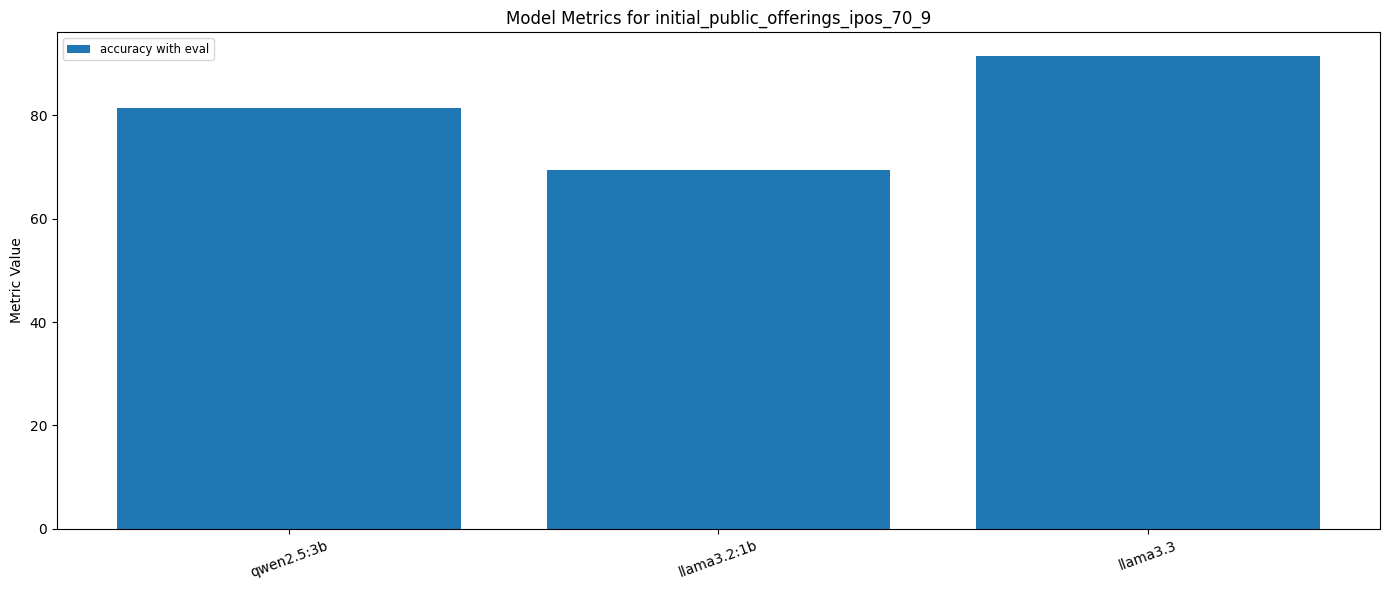

Analyzing metrics for benchmark: news_broadcasting_693_9
Metrics by Model for benchmark 'news_broadcasting_693_9':
      model  accuracy with eval
 qwen2.5:3b                73.3
llama3.2:1b                57.7
   llama3.3                77.9


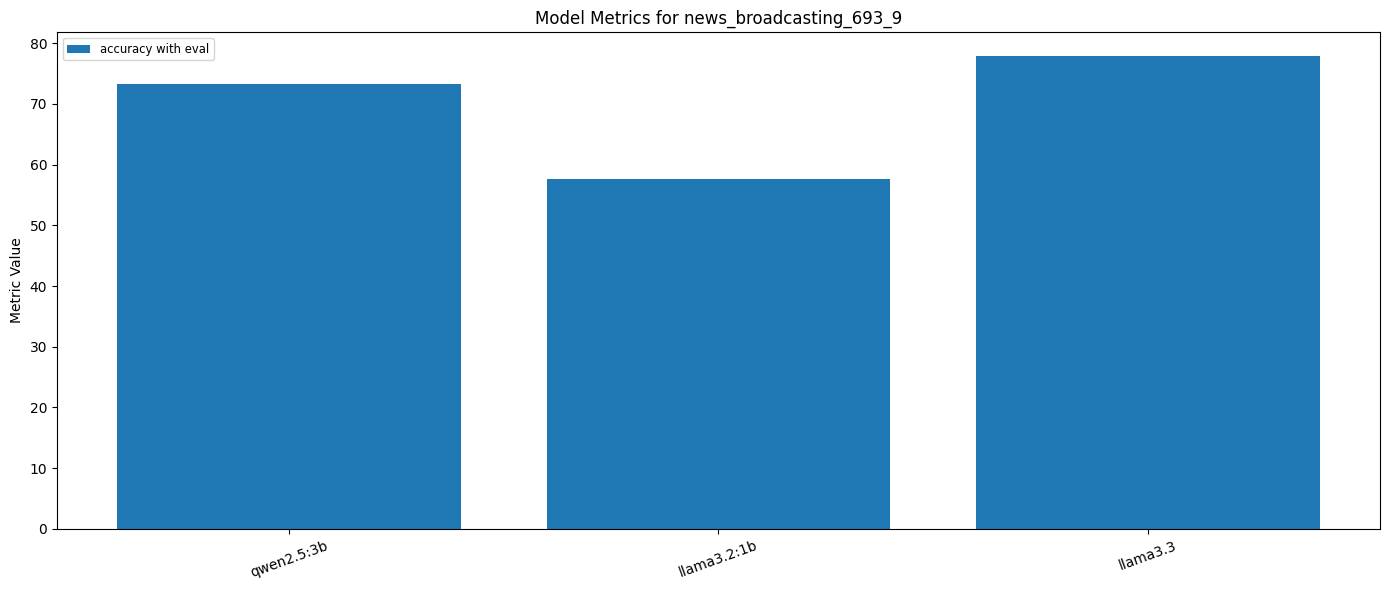

Analyzing metrics for benchmark: prompt_generator
Metrics by Model for benchmark 'prompt_generator':
      model  accuracy with eval
 qwen2.5:3b                66.5
llama3.2:1b                50.0
   llama3.3                85.8


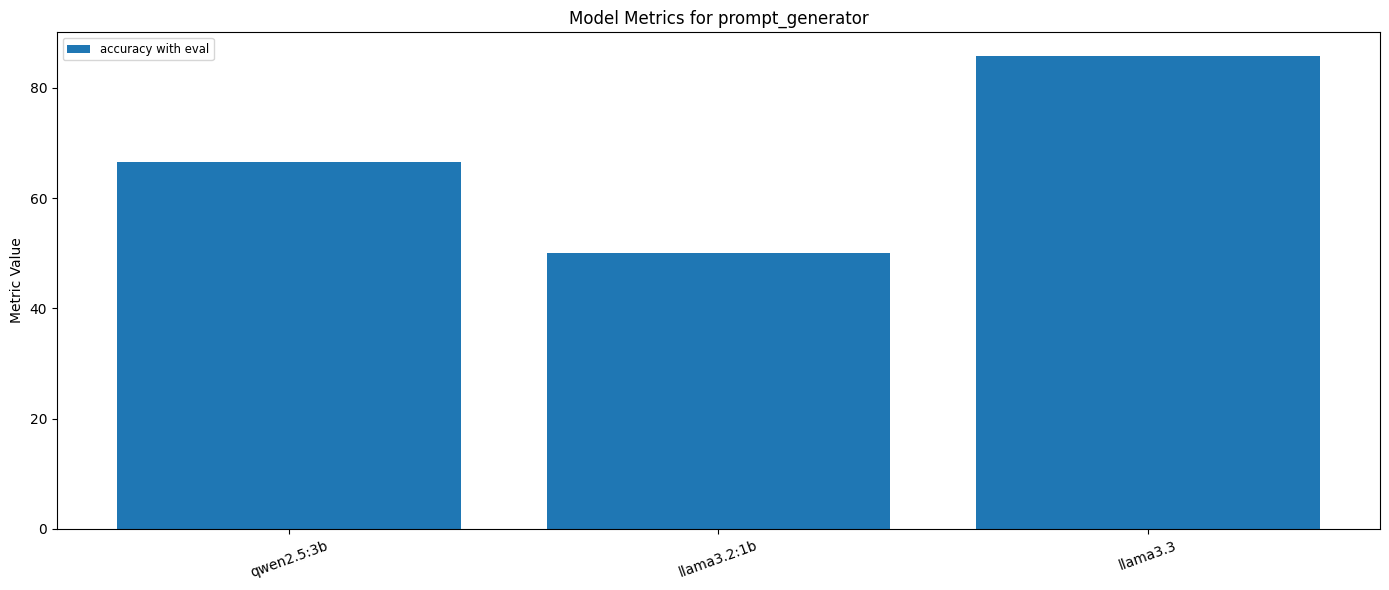

Analyzing metrics for benchmark: real_time_analytics_609_2
Metrics by Model for benchmark 'real_time_analytics_609_2':
      model  accuracy with eval
 qwen2.5:3b                79.8
llama3.2:1b                61.8
   llama3.3                86.6


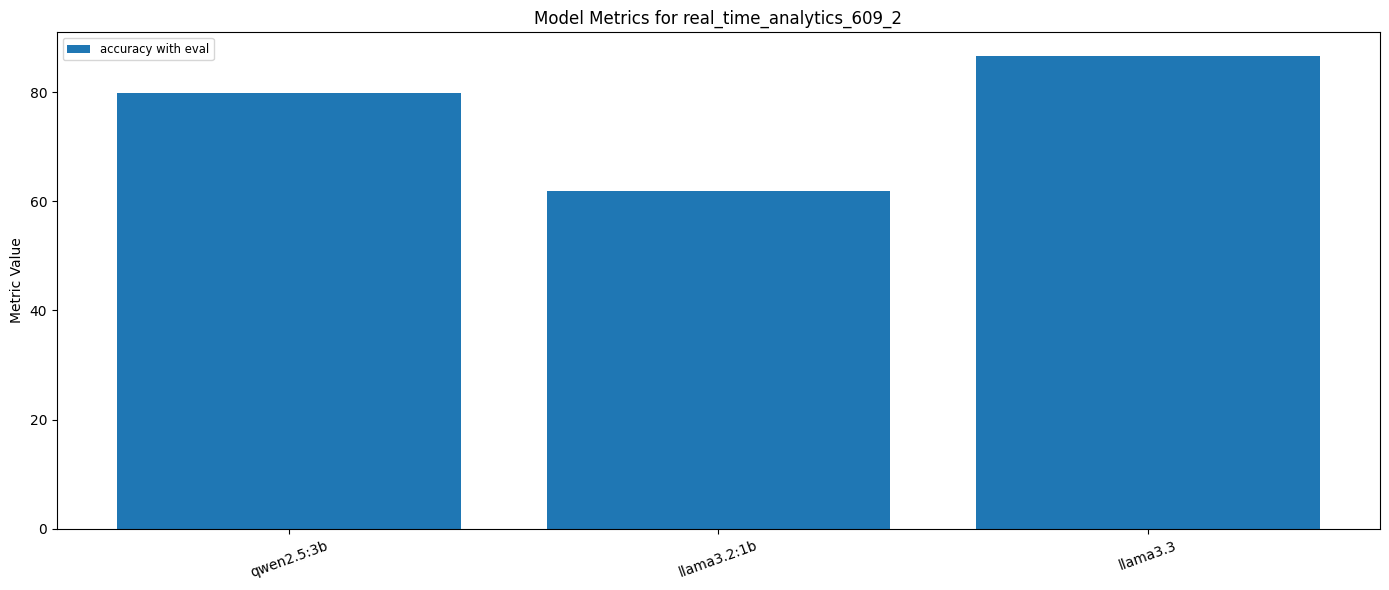

Analyzing metrics for benchmark: recruiter
Metrics by Model for benchmark 'recruiter':
      model  accuracy with eval
 qwen2.5:3b                43.9
llama3.2:1b                65.0
   llama3.3                96.1


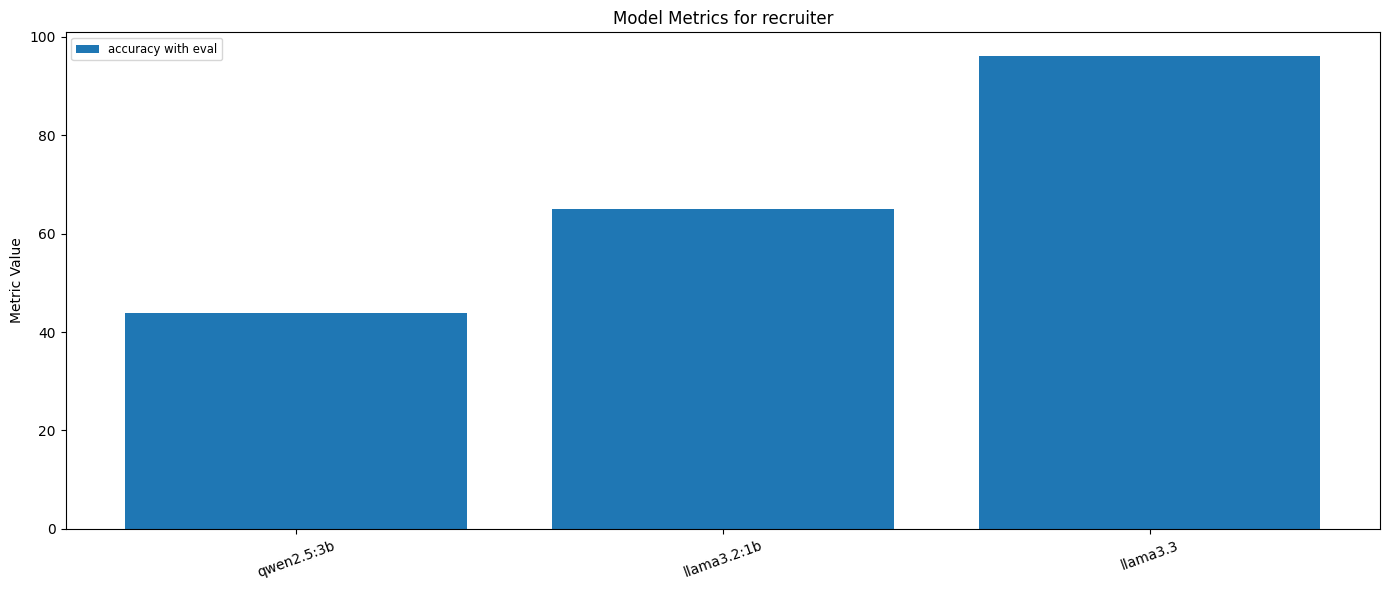

Analyzing metrics for benchmark: restaurant_owner
Metrics by Model for benchmark 'restaurant_owner':
      model  accuracy with eval
 qwen2.5:3b                75.5
llama3.2:1b                69.0
   llama3.3                85.7


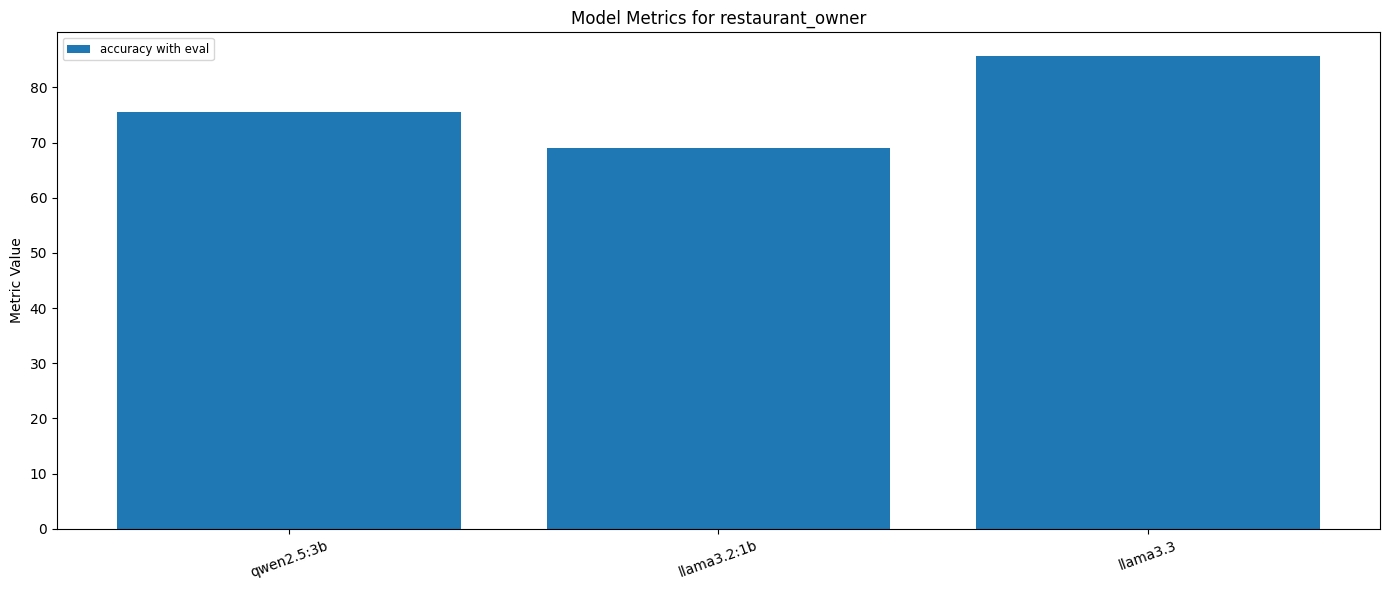

Analyzing metrics for benchmark: sewing_951_7
Metrics by Model for benchmark 'sewing_951_7':
      model  accuracy with eval
 qwen2.5:3b                63.5
llama3.2:1b                56.5
   llama3.3                90.5


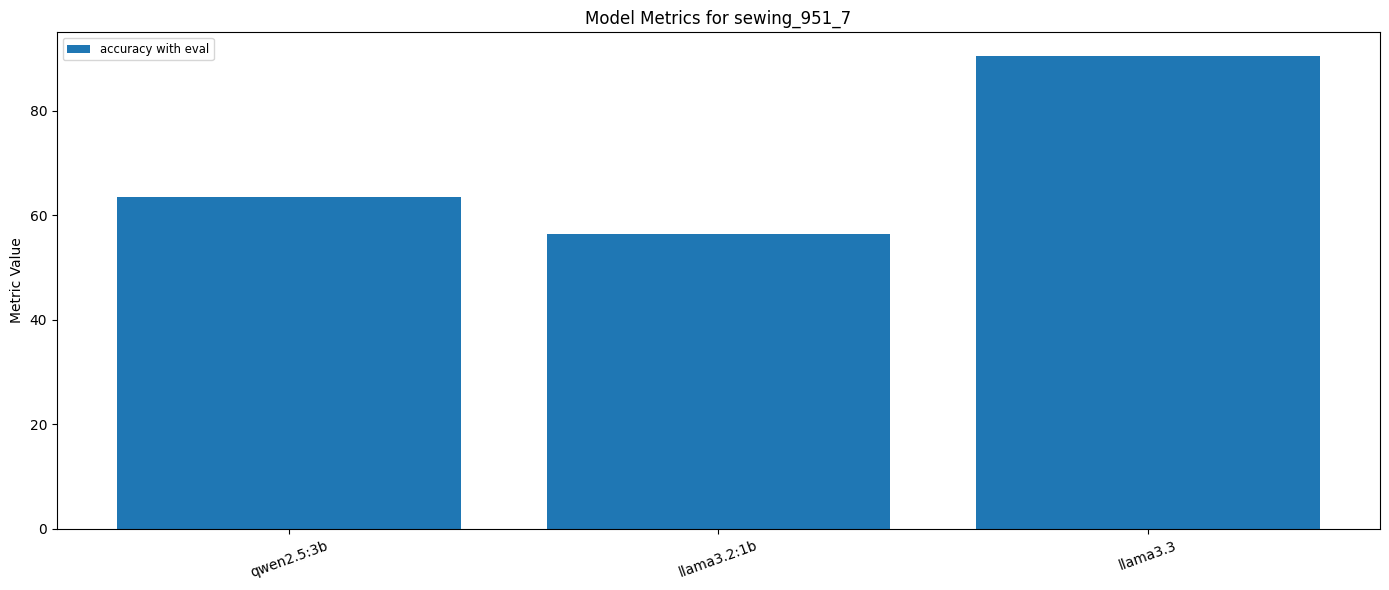

Analyzing metrics for benchmark: solr_search_engine
Metrics by Model for benchmark 'solr_search_engine':
      model  accuracy with eval
 qwen2.5:3b                15.0
llama3.2:1b                 0.0
   llama3.3                29.0


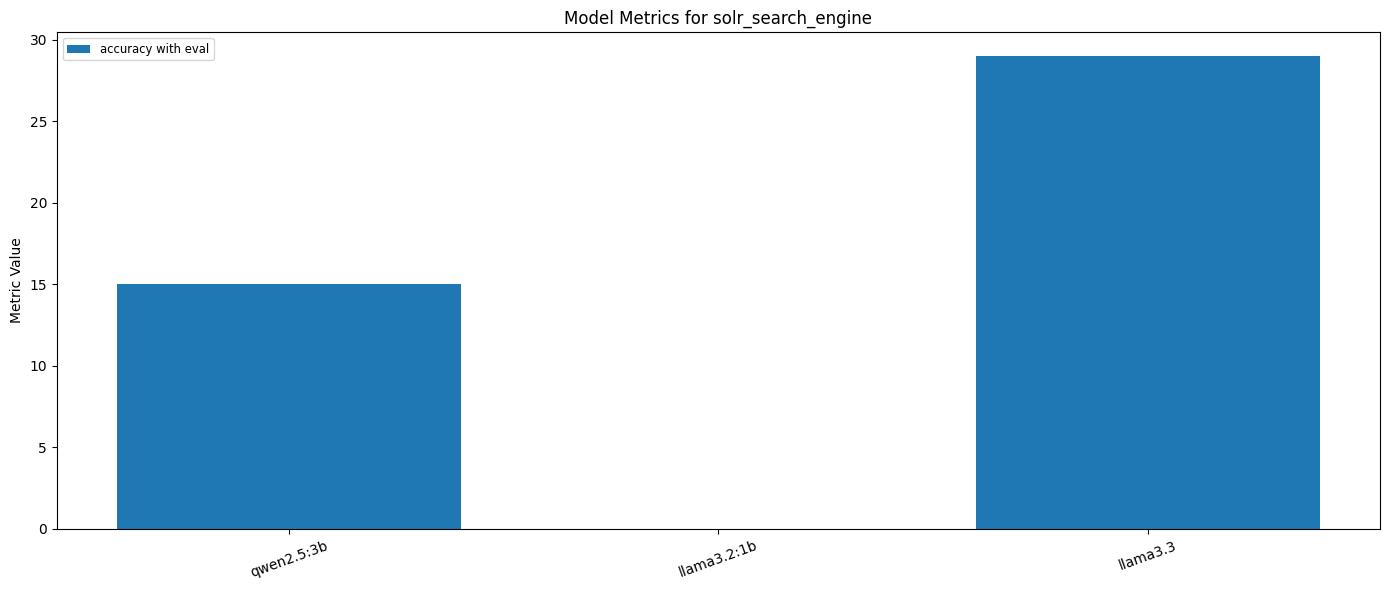

Analyzing metrics for benchmark: speaker_identification_595_2
Metrics by Model for benchmark 'speaker_identification_595_2':
      model  accuracy with eval
 qwen2.5:3b                80.5
llama3.2:1b                65.5
   llama3.3                89.0


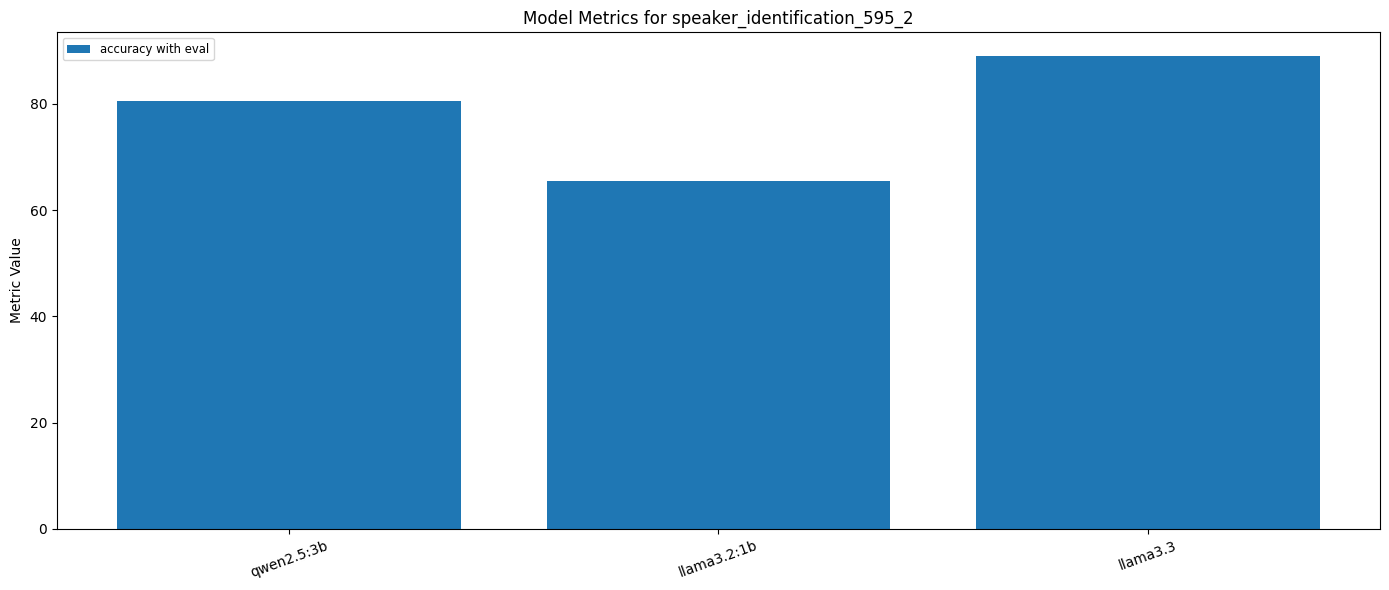

Analyzing metrics for benchmark: startup_idea_generator
Metrics by Model for benchmark 'startup_idea_generator':
      model  accuracy with eval
 qwen2.5:3b                83.7
llama3.2:1b                56.0
   llama3.3                85.9


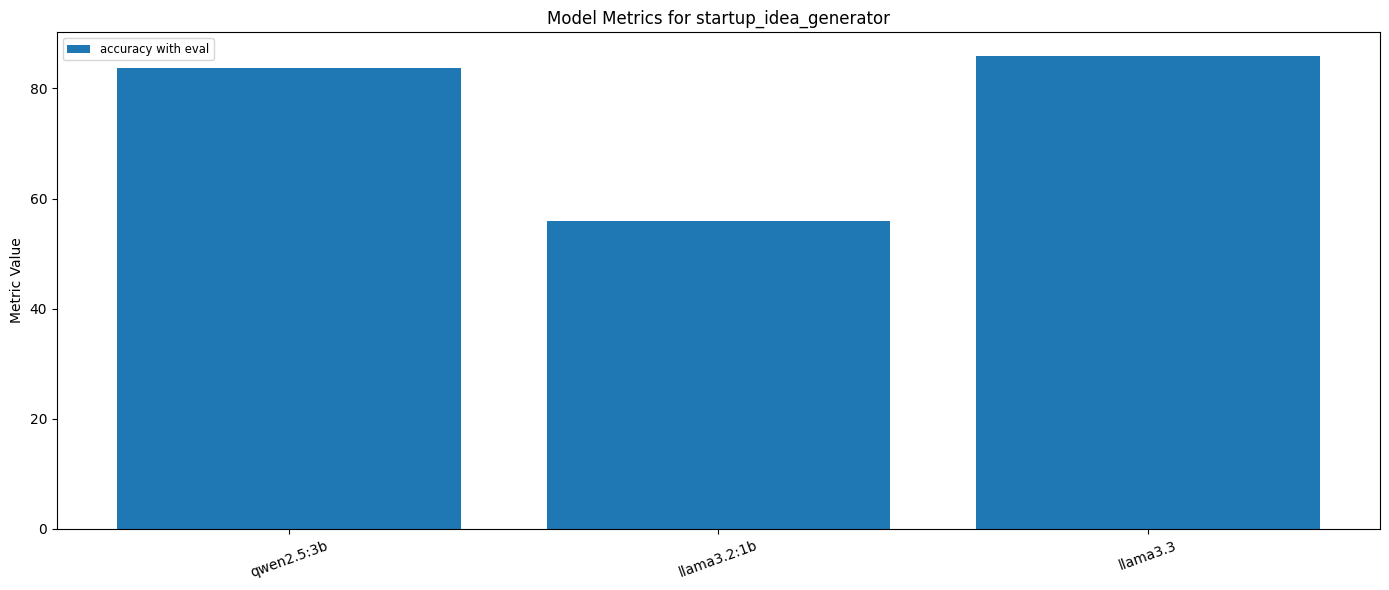

Analyzing metrics for benchmark: tea_taster
Metrics by Model for benchmark 'tea_taster':
      model  accuracy with eval
 qwen2.5:3b                73.1
llama3.2:1b                58.7
   llama3.3                88.6


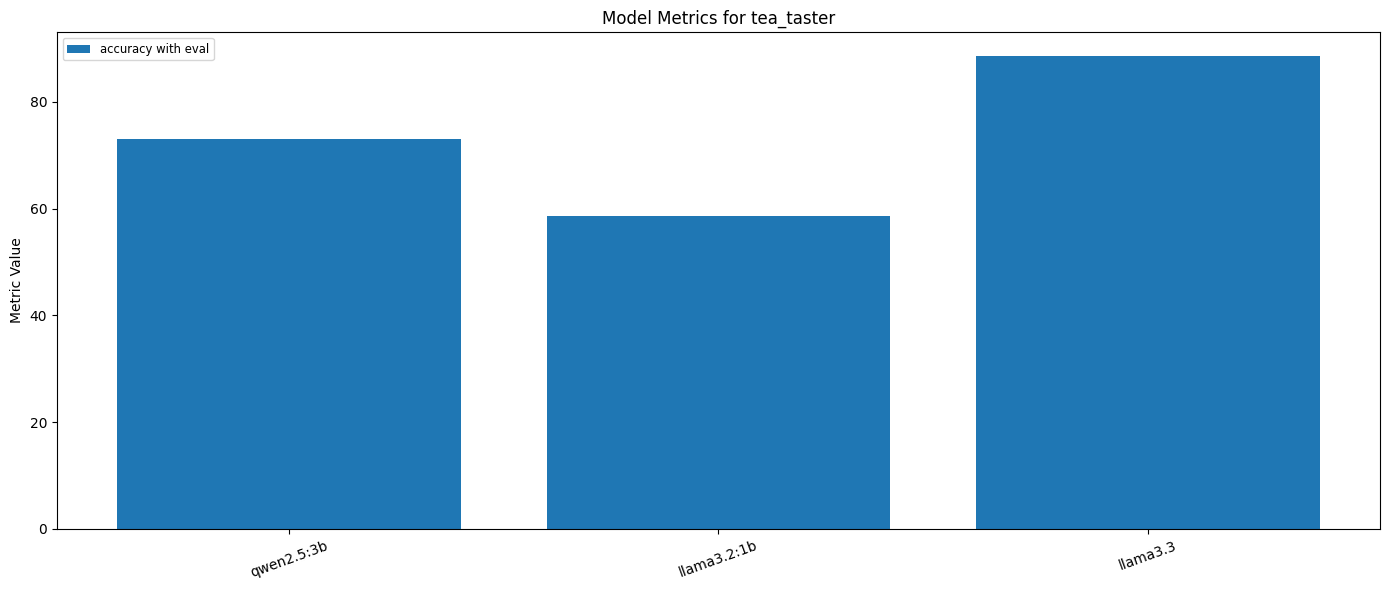

Analyzing metrics for benchmark: virtual_fitness_coach
Metrics by Model for benchmark 'virtual_fitness_coach':
      model  accuracy with eval
 qwen2.5:3b                75.7
llama3.2:1b                56.5
   llama3.3                88.8


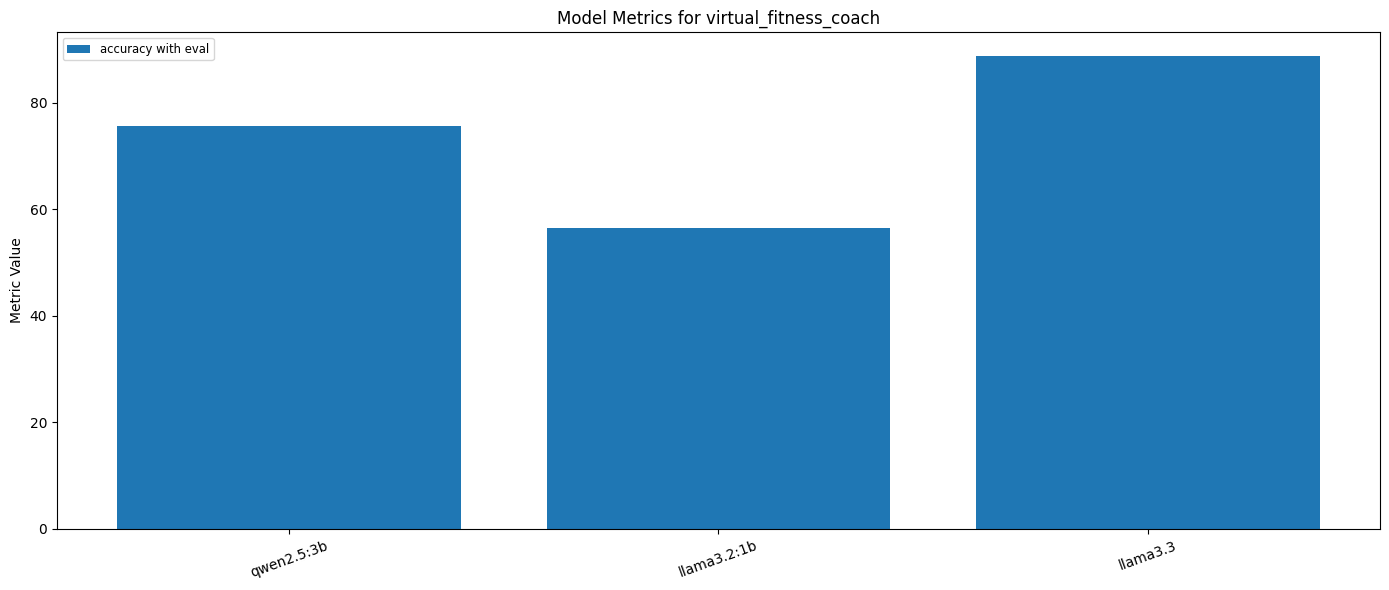

Analyzing metrics for benchmark: yes_or_no_answer
Metrics by Model for benchmark 'yes_or_no_answer':
      model  accuracy with eval
 qwen2.5:3b                70.0
llama3.2:1b                56.5
   llama3.3                84.5


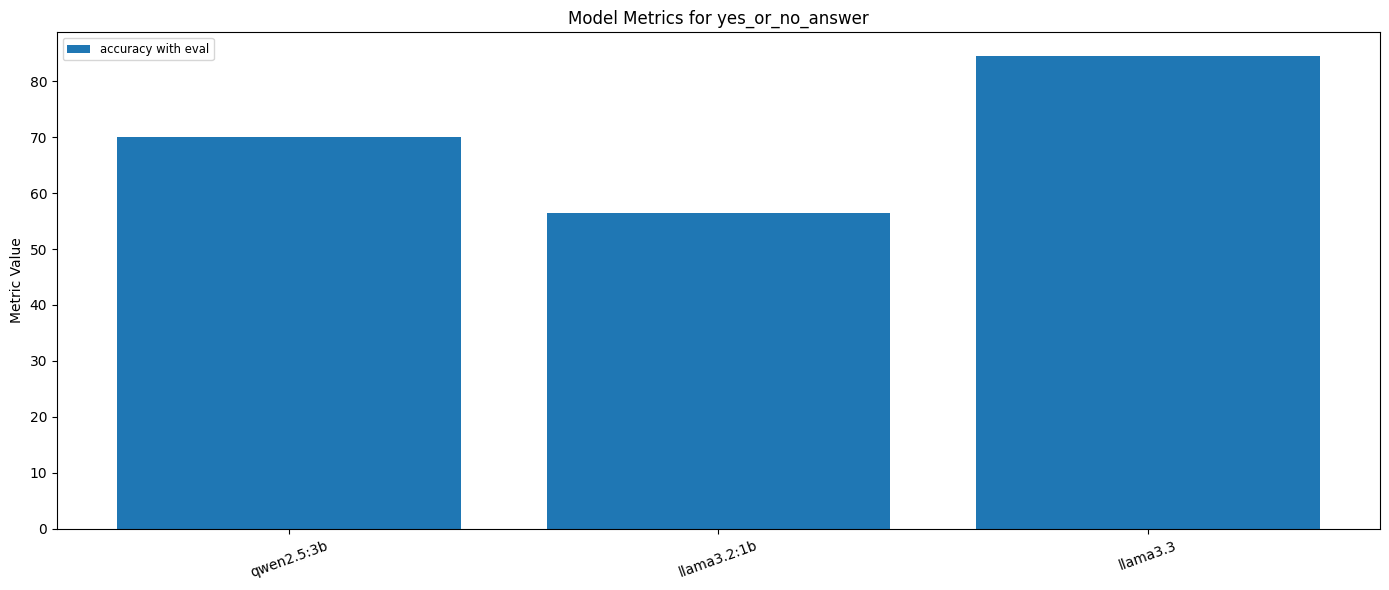

In [34]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

benchmarkVersion = "test-all-2025-09-16-20new-min"

rootDir = "/workspaces/promptpex/"

if not os.path.isdir(rootDir):
    rootDir = ".."

evalsDir = f'{rootDir}/evals/{benchmarkVersion}/'


benchmarks = [
    "speech-tag"
]

# full list
benchmarks = [ "speech-tag", "classify-input-text", "text-to-p",  "sentence-rewrite", "extract-names", "elements", "art-prompt", "shakespearean-writing-assistant"]

benchmarks = [
    "bayesian_games_29_7",
    "bullet_journaling_145_1",
    "canopy_management_298_8",
    "fancy_title_generator",
    "hearing_impairments_124_7",
    "housing_market_dynamics_338_1",
    "initial_public_offerings_ipos_70_9",
    "news_broadcasting_693_9",
    "prompt_generator",
    "real_time_analytics_609_2",
    "recruiter",
    "restaurant_owner",
    "sewing_951_7",
    "solr_search_engine",
    "speaker_identification_595_2",
    "startup_idea_generator",
    "tea_taster",
    "virtual_fitness_coach",
    "yes_or_no_answer"
]


prettyBenchmarkNames = { "speech-tag": "speech-tag", 
                "text-to-p": "text-to-p",  
                "shakespearean-writing-assistant": "shakespeare", 
                "sentence-rewrite": "sentence", 
                "extract-names": "extract-names", 
                "elements":"elements", 
                "art-prompt": "art-prompt", 
                "classify-input-text": "classify"}

prettyMetrics = { "tests compliant": "prompt ok/err", 
                "system_compliant": "prompt only",  
                "rules_system_with_input_compliant": "prompt/rule/input"
}

def parse_metric(val):
    """Convert metric to float, handle %, NaN, and '--'."""
    if isinstance(val, str):
        val = val.strip()
        if val.endswith('%'):
            try:
                return float(val.strip('%'))
            except:
                return 0.0
        if val in ('NaN', '--', ''):
            return 0.0
    try:
        v = float(val)
        if np.isnan(v):
            return 0.0
        return v
    except:
        return 0.0
    
    
def analyze_benchmark_metrics(benchmark, evalsDir, prettyBenchmarkNames):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    # Build the path to the overview.csv for the given benchmark
    csv_path = os.path.join(evalsDir, benchmark, benchmark, "overview.csv")

    # Read the CSV
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()  # Strip whitespace from column names

    # Find the index of the 'metrics' column
    if 'tests negative' in df.columns:
        start_col = df.columns.get_loc('tests negative') + 1
    else:
        start_col = df.columns.get_loc('tests positive') + 1

    # Include "tests compliant" as a metric (ensure it's included)
    metrics = list(df.columns[start_col:])

    # Extract model names and metrics columns
    models = df['model']
    metrics_table = df[['model'] + metrics].copy()

    for metric in metrics:
        metrics_table[metric] = metrics_table[metric].apply(parse_metric)

    print(f"Metrics by Model for benchmark '{benchmark}':")
    print(metrics_table.to_string(index=False))

    # Plot grouped bar chart
    x = np.arange(len(models))
    width = 0.8 / len(metrics)  # total width for all bars per group

    fig, ax = plt.subplots(figsize=(14, 6))
    for i, metric in enumerate(metrics):
        ax.bar(x + i*width, metrics_table[metric], width, label=metric)

    ax.set_xticks(x + width*(len(metrics)-1)/2)
    ax.set_xticklabels(models, rotation=20)
    ax.set_ylabel('Metric Value')
    ax.set_title(f"Model Metrics for {prettyBenchmarkNames.get(benchmark, benchmark)}")
    ax.legend(loc='best', fontsize='small', ncol=2)
    plt.tight_layout()
    plt.show()

# Example usage:
for benchmark in benchmarks:
    # Call the function to analyze and plot metrics for each benchmark
    print(f"Analyzing metrics for benchmark: {benchmark}")
    analyze_benchmark_metrics(benchmark, evalsDir, prettyBenchmarkNames)


Average Metrics by Model:
Model	accuracy with eval
llama3.2:1b	60.72
llama3.3	85.64
qwen2.5:3b	70.85


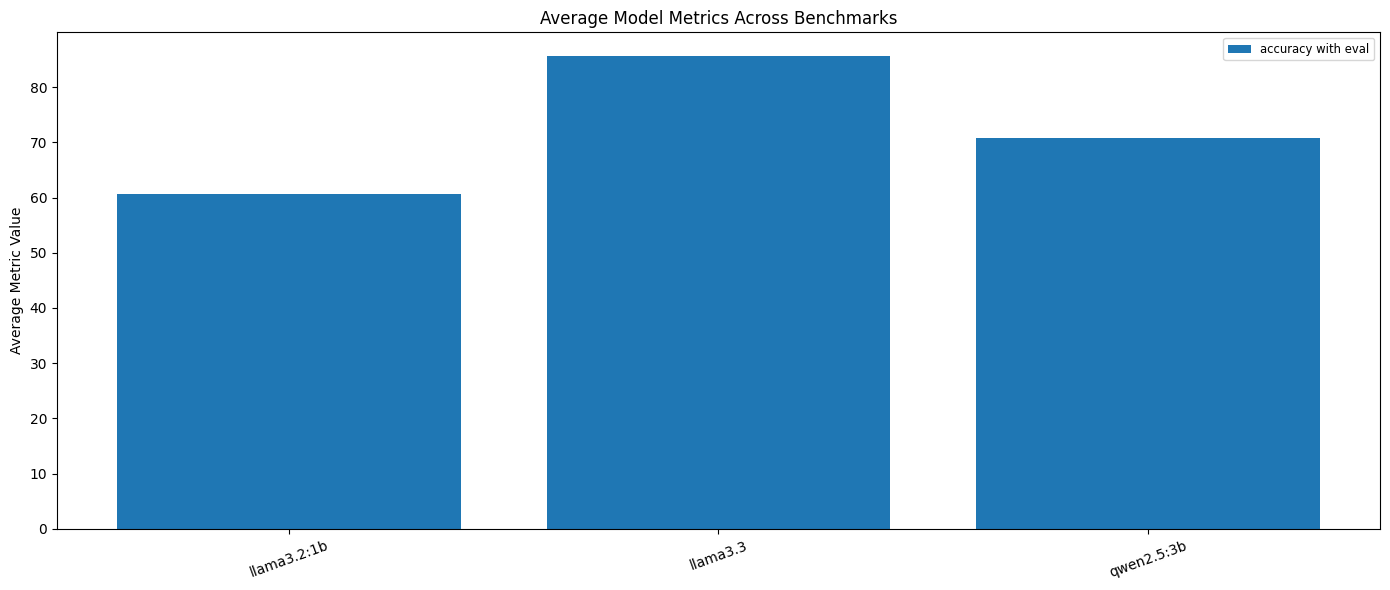

In [35]:


def collect_metrics(benchmarks, evalsDir):
    # Data structure: {benchmark: {model: {metric: value}}}
    all_data = {}
    all_metrics = set()
    all_models = set()

    for benchmark in benchmarks:
        csv_path = os.path.join(evalsDir, benchmark, benchmark, "overview.csv")
        if not os.path.isfile(csv_path):
            print(f"Warning: {csv_path} not found, skipping.")
            continue
        df = pd.read_csv(csv_path)
        df.columns = df.columns.str.strip()

        # Find the index of the 'metrics' column
        if 'tests negative' in df.columns:
            start_col = df.columns.get_loc('tests negative') + 1
        else:
            start_col = df.columns.get_loc('tests positive') + 1

        # Include "tests compliant" as a metric (ensure it's included)
        metrics = list(df.columns[start_col:])

        all_metrics.update(metrics)
        all_data[benchmark] = {}
        for _, row in df.iterrows():
            model = row['model']
            all_models.add(model)
            all_data[benchmark].setdefault(model, {})
            for metric in metrics:
                all_data[benchmark][model][metric] = parse_metric(row[metric])
    return all_data, sorted(all_models), sorted(all_metrics)

def compute_model_metric_averages(all_data, all_models, all_metrics):
    # {model: {metric: [values...]}}
    model_metric_values = {model: {metric: [] for metric in all_metrics} for model in all_models}
    for benchmark in all_data:
        for model in all_models:
            model_metrics = all_data[benchmark].get(model, {})
            for metric in all_metrics:
                val = model_metrics.get(metric, 0.0)
                model_metric_values[model][metric].append(val)
    # Compute averages
    model_metric_avg = {model: {metric: np.mean(vals) for metric, vals in metrics.items()} for model, metrics in model_metric_values.items()}
    return model_metric_avg

def print_metric_table(model_metric_avg):
    models = list(model_metric_avg.keys())
    metrics = list(next(iter(model_metric_avg.values())).keys())
    print("Average Metrics by Model:")
    header = ["Model"] + [prettyMetrics.get(m, m) for m in metrics]
    
    print("\t".join(header))
    for model in models:
        row = [model] + [f"{model_metric_avg[model][metric]:.2f}" for metric in metrics]
        print("\t".join(row))

def plot_grouped_bar_chart(model_metric_avg):
    models = list(model_metric_avg.keys())
    metrics = list(next(iter(model_metric_avg.values())).keys())
    x = np.arange(len(models))
    width = 0.8 / len(metrics)
    fig, ax = plt.subplots(figsize=(14, 6))
    for i, metric in enumerate(metrics):
        values = [model_metric_avg[model][metric] for model in models]
        ax.bar(x + i*width, values, width, label=metric)
    ax.set_xticks(x + width*(len(metrics)-1)/2)
    ax.set_xticklabels(models, rotation=20)
    ax.set_ylabel('Average Metric Value')
    ax.set_title('Average Model Metrics Across Benchmarks')
    ax.legend(loc='best', fontsize='small', ncol=2)
    plt.tight_layout()
    plt.show()



all_data, all_models, all_metrics = collect_metrics(benchmarks, evalsDir)
model_metric_avg = compute_model_metric_averages(all_data, all_models, all_metrics)
print_metric_table(model_metric_avg)
plot_grouped_bar_chart(model_metric_avg)

In [36]:

def print_benchmark_model_metrics_table(benchmarks, evalsDir, columns_of_interest):
    import os
    import pandas as pd
    
    width = 18
    def fit(val):
        s = str(val)
        return s[:width].ljust(width)[:width] 
    
    header = ["Benchmark", "Model"] + [
        prettyMetrics.get(col, col) for col in columns_of_interest
    ]

    print("".join([fit(h) for h in header]))
    for benchmark in benchmarks:
        csv_path = os.path.join(evalsDir, benchmark, benchmark, "overview.csv")
        if not os.path.isfile(csv_path):
            continue
        df = pd.read_csv(csv_path)
        df.columns = df.columns.str.strip()

        for _, row in df.iterrows():
            model = row['model']
            values = []
            for col in columns_of_interest:
                val0 = row.get(col, 0)
                val = parse_metric(val0)
                values.append(f"{val:.2f}")
            print("".join([fit(benchmark), fit(model)] + [fit(v) for v in values]))

# read csv for first benchmark
csv_path = os.path.join(evalsDir, benchmarks[0], benchmarks[0], "overview.csv")
df = pd.read_csv(csv_path)
df.columns = df.columns.str.strip()

# Find the index of the 'metrics' column
if 'tests negative' in df.columns:
    start_col = df.columns.get_loc('tests negative') + 1
else:
    start_col = df.columns.get_loc('tests positive') + 1

# columns_of_interest = ["tests", "tests compliant", "errors", "tests compliance unknown"] + list(df.columns[start_col:])
columns_of_interest = list(df.columns[start_col:])

print_benchmark_model_metrics_table(benchmarks, evalsDir, columns_of_interest)

Benchmark         Model             accuracy with eval
bayesian_games_29_qwen2.5:3b        85.80             
bayesian_games_29_llama3.2:1b       69.00             
bayesian_games_29_llama3.3          94.60             
bullet_journaling_qwen2.5:3b        74.60             
bullet_journaling_llama3.2:1b       66.70             
bullet_journaling_llama3.3          92.00             
canopy_management_qwen2.5:3b        86.30             
canopy_management_llama3.2:1b       72.50             
canopy_management_llama3.3          92.90             
fancy_title_generaqwen2.5:3b        52.50             
fancy_title_generallama3.2:1b       78.50             
fancy_title_generallama3.3          83.50             
hearing_impairmentqwen2.5:3b        90.10             
hearing_impairmentllama3.2:1b       76.50             
hearing_impairmentllama3.3          95.00             
housing_market_dynqwen2.5:3b        74.90             
housing_market_dynllama3.2:1b       67.70             
housing_ma

Benchmark	accuracy with eval
bayesian_games_29_7	249.40
bullet_journaling_145_1	233.30
canopy_management_298_8	251.70
fancy_title_generator	214.50
hearing_impairments_124_7	261.60
housing_market_dynamics_338_1	231.80
initial_public_offerings_ipos_70_9	242.50
news_broadcasting_693_9	208.90
prompt_generator	202.30
real_time_analytics_609_2	228.20
recruiter	205.00
restaurant_owner	230.20
sewing_951_7	210.50
solr_search_engine	44.00
speaker_identification_595_2	235.00
startup_idea_generator	225.60
tea_taster	220.40
virtual_fitness_coach	221.00
yes_or_no_answer	211.00


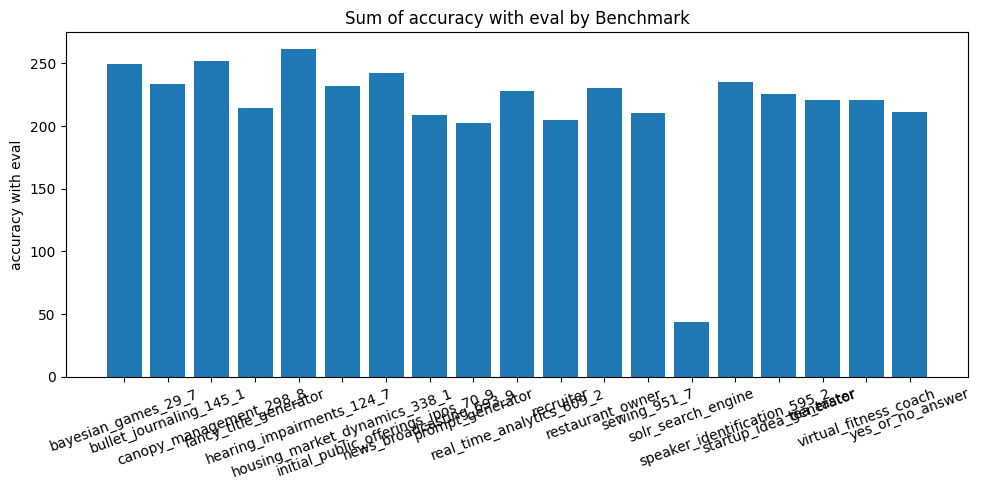

In [37]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def collect_and_sum_benchmark_metrics(benchmarks, evalsDir, columns_of_interest):
    # data[benchmark][model][column]
    data = {}
    sums = {bench: {col: 0.0 for col in columns_of_interest} for bench in benchmarks}
    for benchmark in benchmarks:
        csv_path = os.path.join(evalsDir, benchmark, benchmark, "overview.csv")
        if not os.path.isfile(csv_path):
            print(f"Warning: {csv_path} not found, skipping.")
            continue
        df = pd.read_csv(csv_path)
        df.columns = df.columns.str.strip()
        data[benchmark] = {}
        for _, row in df.iterrows():
            model = row['model']
            data[benchmark][model] = {}
            for col in columns_of_interest:
                val = parse_metric(row.get(col, 0))
                data[benchmark][model][col] = val
                sums[benchmark][col] += val
    return data, sums

def print_sums_table(sums, columns_of_interest):
    print("Benchmark\t" + "\t".join(columns_of_interest))
    for bench, colvals in sums.items():
        row = [bench] + [f"{colvals[col]:.2f}" for col in columns_of_interest]
        print("\t".join(row))

def plot_sums_bar(sums, columns_of_interest):
    benchmarks = list(sums.keys())
    for col in columns_of_interest:
        values = [sums[bench][col] for bench in benchmarks]
        plt.figure(figsize=(10, 5))
        plt.bar(benchmarks, values)
        plt.ylabel(col)
        plt.title(f"Sum of {col} by Benchmark")
        plt.xticks(rotation=20)
        plt.tight_layout()
        plt.show()

# columns_of_interest = ["errors", "tests compliance unknown"]
# Find the index of the 'metrics' column
if 'tests negative' in df.columns:
    start_col = df.columns.get_loc('tests negative') + 1
else:
    start_col = df.columns.get_loc('tests positive') + 1

# columns_of_interest = ["tests", "tests compliant", "errors", "tests compliance unknown"] + list(df.columns[start_col:])
columns_of_interest = list(df.columns[start_col:])

data, sums = collect_and_sum_benchmark_metrics(benchmarks, evalsDir, columns_of_interest)
print_sums_table(sums, columns_of_interest)
plot_sums_bar(sums, columns_of_interest)

Benchmark	Average Tests per Model
bayesian_games_29_7	20.00
bullet_journaling_145_1	20.00
canopy_management_298_8	20.00
fancy_title_generator	20.00
hearing_impairments_124_7	20.00
housing_market_dynamics_338_1	20.00
initial_public_offerings_ipos_70_9	20.00
news_broadcasting_693_9	20.00
prompt_generator	20.00
real_time_analytics_609_2	20.00
recruiter	20.00
restaurant_owner	20.00
sewing_951_7	20.00
solr_search_engine	20.00
speaker_identification_595_2	20.00
startup_idea_generator	20.00
tea_taster	20.00
virtual_fitness_coach	20.00
yes_or_no_answer	20.00


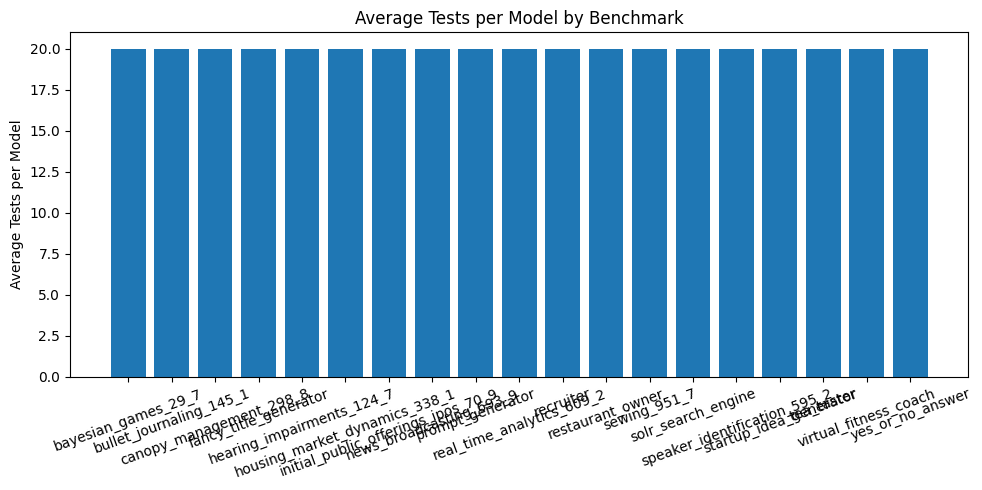

In [38]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



def average_tests_per_model(benchmarks, evalsDir):
    averages = {}
    for benchmark in benchmarks:
        csv_path = os.path.join(evalsDir, benchmark, benchmark, "overview.csv")
        if not os.path.isfile(csv_path):
            print(f"Warning: {csv_path} not found, skipping.")
            continue
        df = pd.read_csv(csv_path)
        df.columns = df.columns.str.strip()
        # Parse the 'tests' column for all models
        tests = df['tests'].apply(parse_metric)
        if len(tests) > 0:
            avg = np.mean(tests)
        else:
            avg = 0.0
        averages[benchmark] = avg
    return averages

def print_avg_table(averages):
    print("Benchmark\tAverage Tests per Model")
    for bench, avg in averages.items():
        print(f"{bench}\t{avg:.2f}")

def plot_avg_bar(averages):
    benchmarks = list(averages.keys())
    values = list(averages.values())
    plt.figure(figsize=(10, 5))
    plt.bar(benchmarks, values)
    plt.ylabel("Average Tests per Model")
    plt.title("Average Tests per Model by Benchmark")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()



averages = average_tests_per_model(benchmarks, evalsDir)
print_avg_table(averages)
plot_avg_bar(averages)

Available columns:
['model', 'tests', 'tests positive', 'tests negative', 'accuracy with eval']

Plotting column: accuracy with eval


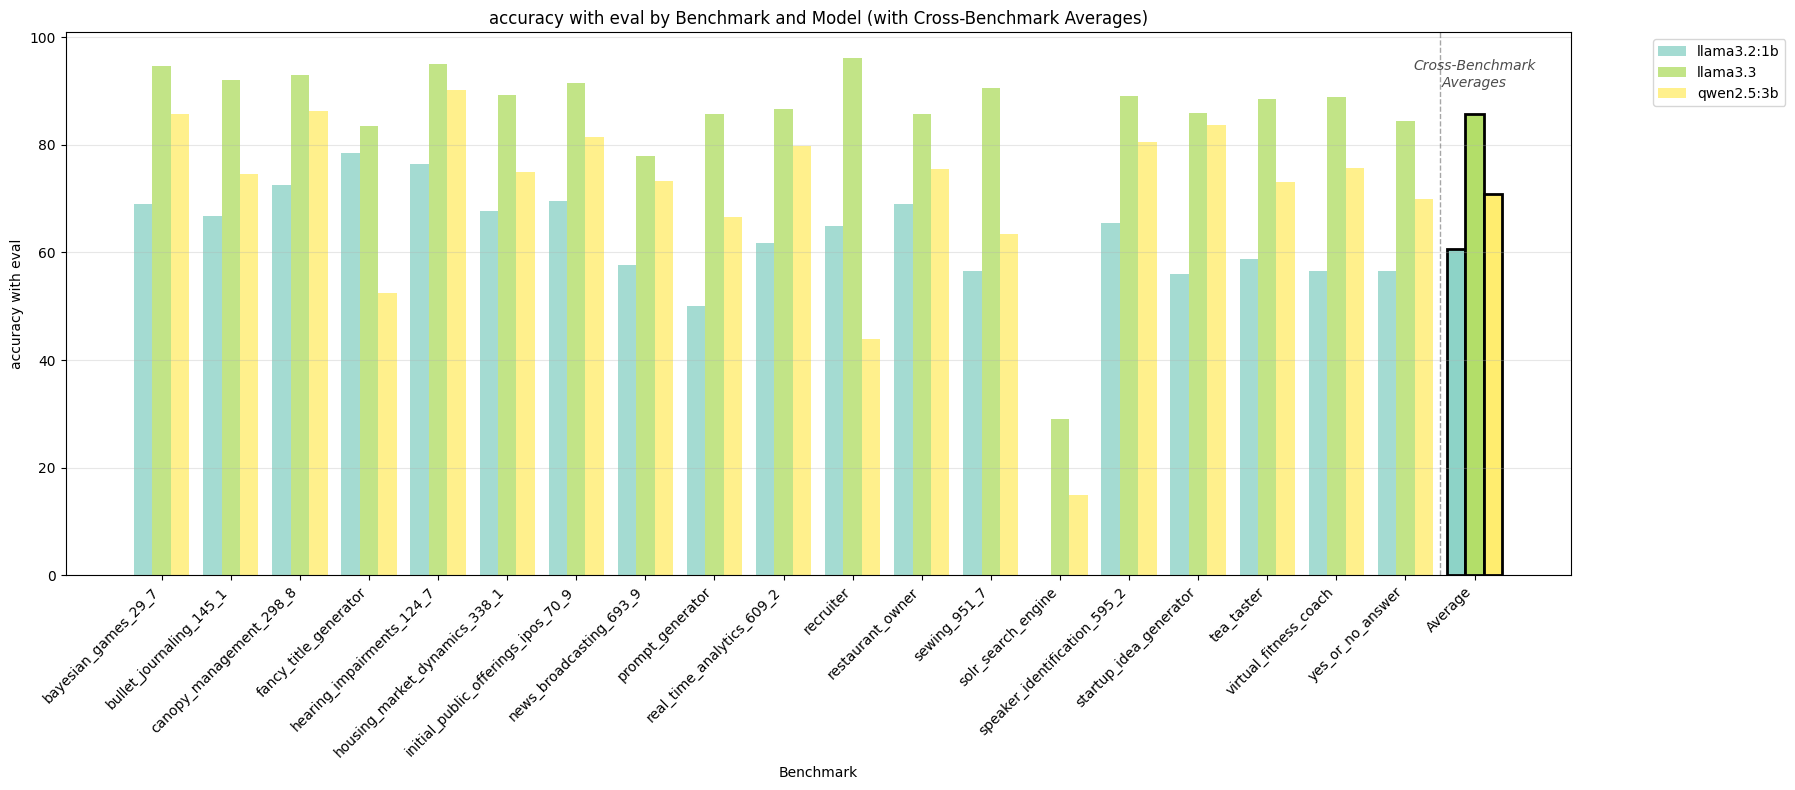

In [39]:
def plot_grouped_barplot_by_benchmark_and_model(benchmarks, evalsDir, column_of_interest):
    """
    Create a grouped barplot showing a specific column as a function of benchmark and model.
    Groups are benchmarks, bars within groups are models.
    Includes an additional "Average" group showing averages across benchmarks for each model.
    """
    import os
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Data structure: {benchmark: {model: value}}
    data = {}
    all_models = set()
    
    for benchmark in benchmarks:
        csv_path = os.path.join(evalsDir, benchmark, benchmark, "overview.csv")
        if not os.path.isfile(csv_path):
            print(f"Warning: {csv_path} not found, skipping.")
            continue
        df = pd.read_csv(csv_path)
        df.columns = df.columns.str.strip()
        
        if "model" not in df.columns or column_of_interest not in df.columns:
            print(f"Warning: Required columns not found in {csv_path}, skipping.")
            continue
            
        data[benchmark] = {}
        for _, row in df.iterrows():
            model = row["model"]
            val = parse_metric(row[column_of_interest])
            data[benchmark][model] = val
            all_models.add(model)
    
    all_models = sorted(all_models)
    benchmarks_with_data = [b for b in benchmarks if b in data]
    
    if not benchmarks_with_data or not all_models:
        print("No data found for plotting.")
        return
    
    # Build data matrix: rows=benchmarks, columns=models
    values = []
    for benchmark in benchmarks_with_data:
        row = []
        for model in all_models:
            row.append(data.get(benchmark, {}).get(model, 0.0))
        values.append(row)
    values = np.array(values)  # shape: (num_benchmarks, num_models)
    
    # Calculate averages across benchmarks for each model
    model_averages = []
    for i, model in enumerate(all_models):
        # Get values for this model across all benchmarks
        model_values = values[:, i]
        # Only average non-zero values (or all values if you prefer)
        avg = np.mean(model_values)
        model_averages.append(avg)
    
    # Add the average row to the data
    all_values = np.vstack([values, model_averages])
    all_labels = benchmarks_with_data + ["Average"]
    
    # Create the grouped bar plot
    x = np.arange(len(all_labels))  # positions for all groups including average
    width = 0.8 / len(all_models)  # width of individual bars
    
    fig, ax = plt.subplots(figsize=(18, 8))
    
    # Create bars for each model
    colors = plt.cm.Set3(np.linspace(0, 1, len(all_models)))  # Use distinct colors
    for i, model in enumerate(all_models):
        offset = (i - (len(all_models) - 1) / 2) * width
        bars = ax.bar(x + offset, all_values[:, i], width, label=model, alpha=0.8, color=colors[i])
        
        # Highlight the average bars with different styling
        if len(bars) > len(benchmarks_with_data):
            bars[-1].set_alpha(1.0)  # Make average bar more opaque
            bars[-1].set_edgecolor('black')  # Add black border to average bar
            bars[-1].set_linewidth(2)
    
    # Add a vertical separator line before the average group
    if len(all_labels) > 1:
        separator_x = len(benchmarks_with_data) - 0.5
        ax.axvline(x=separator_x, color='gray', linestyle='--', alpha=0.7, linewidth=1)
    
    # Customize the plot
    ax.set_xlabel('Benchmark')
    ax.set_ylabel(column_of_interest)
    ax.set_title(f'{column_of_interest} by Benchmark and Model (with Cross-Benchmark Averages)')
    ax.set_xticks(x)
    ax.set_xticklabels(all_labels, rotation=45, ha='right')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add text annotation for the average section
    if len(all_labels) > 1:
        ax.text(len(benchmarks_with_data), ax.get_ylim()[1] * 0.95, 'Cross-Benchmark\nAverages', 
                ha='center', va='top', fontsize=10, style='italic', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Example usage with a specific column
# You can change this to any column that exists in your data
column_to_plot = "tests compliant"

# First check what columns are available in the first benchmark
csv_path = os.path.join(evalsDir, benchmarks[0], benchmarks[0], "overview.csv")
if os.path.isfile(csv_path):
    df_sample = pd.read_csv(csv_path)
    df_sample.columns = df_sample.columns.str.strip()
    print("Available columns:")
    print(df_sample.columns.tolist())
    print()
    
    # Try to find a good column to plot
    if "tests compliant" in df_sample.columns:
        column_to_plot = "tests compliant"
    elif "accuracy with eval" in df_sample.columns:
        column_to_plot = "accuracy with eval"
    else:
        # Use the first metric column after standard columns
        if 'tests negative' in df_sample.columns:
            start_col = df_sample.columns.get_loc('tests negative') + 1
        elif 'tests positive' in df_sample.columns:
            start_col = df_sample.columns.get_loc('tests positive') + 1
        else:
            start_col = df_sample.columns.get_loc('model') + 1 if 'model' in df_sample.columns else 0
        
        if start_col < len(df_sample.columns):
            column_to_plot = df_sample.columns[start_col]

print(f"Plotting column: {column_to_plot}")
plot_grouped_barplot_by_benchmark_and_model(benchmarks, evalsDir, column_to_plot)